# Midterm 3 Assignment 1 Davide Amadei

## Imports

In [130]:
import numpy as np
from typing import Iterator
import os

# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# torchvision imports
import torchvision
from torchvision import datasets, transforms

# plot imports
from matplotlib import pyplot as plt

Use GPU if available, CPU otherwise

In [131]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Utility functions

In [178]:
def plot_comparison(data_list: list[torch.tensor], label_list: list[str],
                indices: list[int], figsize: tuple[float, float] = None) -> None:
    """simple function to plot comparisons between original images 
       and the ones reconstructed by the autoencoder

    Parameters
    ----------
    data_list : list[torch.tensor]
        list of data to show
    label_list : list[str]
        labels to use for the images
    indices : list[int]
        indices of images to show
    figsize : tuple[float, float], optional
        size of the image to be shown. If None use (len(data_list)*1.5, 3) as size, by default None
    """
    if figsize is None:
        figsize = (len(data_list)*1.5, 3)

    fig, axes = plt.subplots(len(indices), len(data_list), figsize=figsize)

    for i, index in enumerate(indices):
        for j, data in enumerate(data_list):
            # row 1, original image
            ax = axes[i, j]
            ax.axis("off")
            if i == 0:
                ax.set_title(f"{label_list[j]}")
            ax.imshow(data[index], cmap="gray")
        
    plt.show()

In [133]:
def plot_list(indices: list[int], data:torch.tensor, labels: list[str] = None,
              figsize:tuple[float, float]=None) -> None:
    """simple function to plot a list of images

    Parameters
    ----------
    indices : list[int]
        list of indices of the data to be shown
    og : torch.tensor
        data containing images to show
    labels : list[str]
        labels of the images to plot
    figsize : tuple[float, float], optional
        size of the image to be shown. If None use (len(indices)*1.5, 3) as size, by default None
    """
    if figsize is None:
        figsize = (len(indices)*1.5, 3)

    fig, axes = plt.subplots(1, len(indices), figsize=figsize)

    for i, index in enumerate(indices):
        ax = axes[i]
        ax.axis("off")
        if labels is not None:
          ax.set_title(labels[i])
        ax.imshow(data[index], cmap="gray")

    plt.show()

In [134]:
def plot_loss(training_loss: list, validation_loss:list, title: str) -> None:
    """function to plot the loss over the epochs

    Parameters
    ----------
    training_loss : list
        list of loss values for training data
    validation_loss : list
        list of loss values for validation data
    title : str
        title to use for the plot
    """
    fig, ax = plt.subplots()
    ax.plot(training_loss, color='blue', label='Training')
    ax.plot(validation_loss, color='orange', label='Validation')
    ax.legend(loc='upper right')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE')
    ax.set_title(title)
    plt.show()

Iterator that returns minibatches of given data and targets.

In [135]:
def get_minibatches(
        data: torch.Tensor, targets: torch.tensor, batchsize: int
    ) -> Iterator[tuple[torch.Tensor, torch.Tensor]]:
        """Returns minibatches of given size over (x, y).

        Parameters
        ----------
        data : torch.Tensor
            data tensor
        targets : torch.Tensor
            targets tensor
        batchsize : int
            batch size of yielded minibatches

        Yields
        ------
        Iterator[tuple[torch.Tensor,torch.Tensor]]
            iterator over minibatches
        """
        if batchsize in [None, 0, -1]:
            batchsize = data.shape[0]
        size = data.shape[0]
        batchtotal, remainder = divmod(size, batchsize)
        for i in range(batchtotal):
            mini_data = data[i * batchsize : (i + 1) * batchsize]
            mini_targets = targets[i * batchsize : (i + 1) * batchsize]
            yield (mini_data, mini_targets)
        if remainder > 0:
            yield (data[batchtotal * batchsize :], targets[batchtotal * batchsize :])

Utility function to train a model to avoid writing the same code multiple times.

In [136]:
def train(model: nn.Module, tr_data: torch.tensor, tr_target: torch.tensor,
          val_data: torch.tensor, val_target: torch.tensor,
          optimizer: torch.optim.Optimizer, criterion, 
          batchsize:int = 128, max_epochs:int = 20, 
          print_frequency: int = 10) -> tuple[list, list]:
  """function to train a model with the given data and parameters

  Parameters
  ----------
  model : nn.Module
      model to train
  tr_data : torch.tensor
      training data to use
  tr_target : torch.tensor
      targets of training data
  val_data : torch.tensor
      validation data to use
  val_target : torch.tensor
      targets of validation data
  optimizer : torch.optim.Optimizer
      optimizer to use
  criterion : 
      loss function to use
  batchsize : int, optional
      size of each mini batch, by default 128
  max_epochs : int, optional
      max number of epochs of training, by default 20
  print_frequency : int, optional
      how often to print current loss, by default 10

  Returns
  -------
  tuple[list, list]
      list of loss values for training data and for validation data
  """
  tr_loss_list = []
  val_loss_list = []

  for epoch in range(max_epochs):
    epoch_loss = 0.0
    model.train()

    for i, (inputs, targets) in enumerate(get_minibatches(tr_data, 
                                                        tr_target, 
                                                        batchsize)):
      # forward
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # backward
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.data

    # validation
    if val_data is not None and val_target is not None:
      model.eval()
      with torch.no_grad():
        val_preds = model(val_data)
        val_loss = criterion(val_preds, val_target)
        val_loss_list.append(val_loss.cpu())
      
      if (epoch+1) % print_frequency == 0:
        print(f"[{epoch + 1}]" 
              f" Loss: {epoch_loss / (i+1):.5f}"
              f" Validation loss: {val_loss:.5f}")
    else:
      if (epoch+1) % print_frequency == 0:
        print(f"[{epoch + 1}]" 
              f" Loss: {epoch_loss / (i+1):.5f}")
      
    tr_loss_list.append((epoch_loss / (i+1)).cpu())
    epoch_loss = 0.0
  return tr_loss_list, val_loss_list

## Loading dataset and preprocessing

Download the MNIST dataset, both training and test set.

In [137]:
if os.path.exists("./data/MNIST/"):
  download = False
else:
  download = True

tr_mnist_dataset = datasets.MNIST("./data/MNIST/", download=download, train=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                         ]))

tr_mnist = tr_mnist_dataset.data / 255
tr_mnist_labels = tr_mnist_dataset.targets

ts_mnist = (datasets.MNIST("./data/MNIST/", download=download, train=False,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                         ])).data) / 255

Add noise to the images from normal distribution with given scale and keep the original images as the target output to be used in training.

In [138]:
scale = 0.3

tr_data_noisy = (tr_mnist + scale * 
                       torch.randn(tr_mnist.shape)).to(device)
tr_target = tr_mnist.to(device)

ts_data_noisy = (ts_mnist + scale * 
                       torch.randn(ts_mnist.shape)).to(device)
ts_target = ts_mnist.to(device)

Clip the data to be in range [0, 1].

In [139]:
tr_data_noisy = torch.clip(tr_data_noisy, 0., 1.)
ts_data_noisy = torch.clip(ts_data_noisy, 0., 1.)

Split the training set to keep a validation set. The last third of the training set is used as validation.

In [140]:
val_split = 40000

val_data = tr_mnist[val_split:]
val_labels = tr_mnist_labels[val_split:]

val_data_noisy = tr_data_noisy[val_split:]
tr_data_noisy = tr_data_noisy[:val_split]

val_target = tr_target[val_split:]
tr_target = tr_target[:val_split]

Examples of the noisy images obtained, one for each digit.

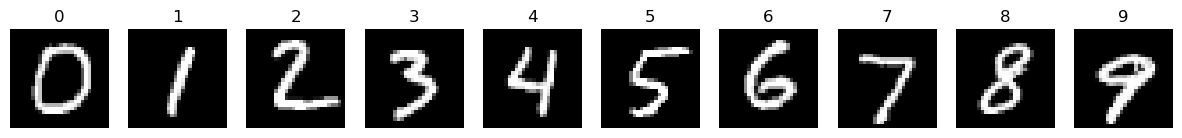

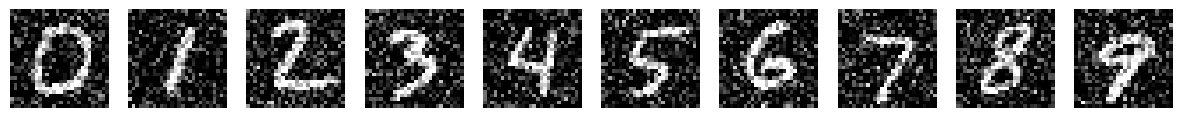

In [141]:
indices = [10, 5, 1, 30, 27, 2798, 1831, 0, 110, 9]
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

plot_list(indices, ts_mnist.cpu(), labels)
plot_list(indices, ts_data_noisy.cpu())

## Model creation

Single layer denoising autoencoder, using ReLU as the activation function for the hidden layer and sigmoid for the output, so as to keep the outputs in the range [0, 1].

In [142]:
class single_layer_denoising_autoencoder(nn.Module):
  """class implementing a single layer denoising autoencoder
  """
  def __init__(self, n_units=100):
    """init function

    Parameters
    ----------
    n_units : int, optional
        number of units in the hidden layer, by default 100
    """
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, n_units),
        nn.ReLU()
    )
    self.decoder = nn.Sequential(
        nn.Linear(n_units, 28*28),
        nn.Sigmoid(),
        nn.Unflatten(1, (28, 28))
    )
    self.apply(self._init_weights)
  
  def forward(self, x: torch.tensor) -> torch.tensor:
    """forward method of the model

    Parameters
    ----------
    x : torch.tensor
        the input data

    Returns
    -------
    torch.tensor
        the output of the net given the input
    """
    x = self.encoder(x)
    x = self.decoder(x)
    return x

  def _init_weights(self, module: nn.Module) -> None:
    """function to initialize weights and biases of a given module

    Parameters
    ----------
    module : nn.Module
        module to be initialized
    """
    if isinstance(module, nn.Linear):
      nn.init.xavier_uniform_(module.weight)
      module.bias.data.zero_()

Deep layer autoencoder with layerwise pretraining. When created the model accepts a list of integer to be used as the number of units in each layer. In the final model the decoder uses a symmetric structure to the encoder, so as to decode each intermediate encoding instead of using a single decoding layer to directly get the reconstructed output from the final encoding. <br>

For each layer the training works as follows. First, train the model as usual. After stopping the training, get the current encoding of the training and validation data, as they must be used as inputs in the following training phase. Then, the add_layer method must be called, which freezes the weights of the current encoding layer, removes the current decoder, and adds new encoding and decoding layer. <br>

When all the layers have been added, the finalize_structure method must be called, freezing the last encoding layer and building the previously described decoder. During the layerwise pretraining the weights of the decoders are also stored, so they can be optionally reused to initialize the final decoder instead of having to train it from scratch. <br>

Fine tuning of the encoder can be enabled or disabled at will by calling the fine_tuning method, which freezes or unfreezes the weights depending on the value passed to the function. <br>

The weights are always initialized using Xavier uniform initialization, while biases are initialized to 0.

In [143]:
class deep_denoising_autoencoder(nn.Module):
  """class implementing a deep denoising autoencoder where the training is done
  using layerwise pretraining of each encoding layer
  """
  def __init__(self, layers: list[int] = [500, 100], loaded: bool = False):
    """init function

    Parameters
    ----------
    layers : list[int], optional
        list of sizes for each layer, by default [500, 100]
    loaded : bool, optional
        wether the model is being reloaded from a saved checkpoint of a previously saved model.
        If True skips most initialization steps to create an empty model to be restored with
        already existing data, by default False
    """
    super().__init__()
    if not loaded:
      self.finalized = loaded
      self.current_layer = 0
      self.layers = layers
      self.encoder = nn.Sequential(
          nn.Flatten(start_dim=1),
          nn.Linear(28*28, self.layers[self.current_layer]),
          nn.ReLU()
      )
      self.decoder = nn.Sequential(
          nn.Linear(self.layers[self.current_layer], 28*28),
          nn.Sigmoid(),
          nn.Unflatten(1, (28, 28))
      )

      self.old_decoder_weights = []
      self.old_decoder_biases = []

      self.apply(self._init_weights)
    else:
      self.finalized = loaded
      self.encoder = nn.Sequential()
      self.decoder = nn.Sequential()
  
  def forward(self, x: torch.tensor) -> torch.tensor:
    """forward method of the model

    Parameters
    ----------
    x : torch.tensor
        the input data

    Returns
    -------
    torch.tensor
        the output of the net given the input
    """
    x = self.encoder(x)
    x = self.decoder(x)
    return x

  def encode(self, x: torch.tensor) -> torch.tensor:
    """function to encode the given input

    Parameters
    ----------
    x : torch.tensor
        input to be encoded

    Returns
    -------
    torch.tensor
        encoding of the input data
    """
    with torch.no_grad():
      encoding = self.encoder(x)
    return encoding

  def decode(self, x: torch.tensor) -> torch.tensor:
    """function to decode the given input

    Parameters
    ----------
    x : torch.tensor
        input to be decoded

    Returns
    -------
    torch.tensor
        decoding of the input
    """
    with torch.no_grad():
      decoded_x = self.decoder(x)
    return decoded_x

  def add_layer(self) -> None:
    """function to add the next encoding layer

    Raises
    ------
    ValueError
        when no more layers can be added or the model is being reloaded from a previous checkpoint 
    """

    if self.finalized:
      raise ValueError("Cannot add more layers, the model has already been finalized")

    # if layers were already all added or the model has been reloaded from a previous checkpoint
    # raise an error
    if self.current_layer >= len(self.layers)-1:
      raise ValueError("Cannot add more layers, the finalize_structure method must be called")
    
    with torch.no_grad():
      # freeze previous encoding layer
      index = self.current_layer * 2 + 1
      self.encoder[index].weight.requires_grad = False
      self.encoder[index].bias.requires_grad = False

      # append new encoding layer to encoder
      self.encoder.append(nn.Linear(self.layers[self.current_layer],
                                    self.layers[self.current_layer+1]))
      
      if self.current_layer != len(self.layers)-2:
        self.encoder.append(nn.ReLU())
      
      # save weights of the current decoder
      self.old_decoder_weights.append(self.decoder[0].weight)
      self.old_decoder_biases.append(self.decoder[0].bias)

      # initialize new decoder
      self.decoder = nn.Sequential(
          nn.Linear(self.layers[self.current_layer+1],
                    self.layers[self.current_layer]),
      )

      self.decoder.append(nn.ReLU())

      # initialize weights for newly added layers
      self._init_weights(self.encoder[-2])
      self._init_weights(self.decoder)

      self.current_layer += 1  

  def finalize_structure(self, reuse_weights = True) -> None:
    """method to finalize the structure of the model

    Parameters
    ----------
    reuse_weights : bool, optional
        flag determining if the weights of the decoding layers
        obtained during layerwise pretraining must be reused
        to initialize the weights in the final model, by default True

    Raises
    ------
    ValueError
    """

    if self.current_layer < len(self.layers)-1:
      raise ValueError("The model has more layers that need to be added")

    if self.finalized:
      raise ValueError("The model has already been finalized")

    with torch.no_grad():
      # freeze last encoding layer
      index = self.current_layer * 2 + 1
      self.encoder[index].weight.requires_grad = False
      self.encoder[index].bias.requires_grad = False

      # save weights of the last decoder
      self.old_decoder_weights.append(self.decoder[0].weight)
      self.old_decoder_biases.append(self.decoder[0].bias)

      # initialize new decoder
      self.decoder = nn.Sequential()

      # insert decoding layers into the decoder
      for i in range(len(self.layers)-1, 0, -1):
        decoder_layer = nn.Linear(self.layers[i],
                                  self.layers[i-1])
        
        # initialize weights with existing ones if flag is set
        if reuse_weights:
          decoder_layer.weight.copy_(self.old_decoder_weights[i])
          decoder_layer.bias.copy_(self.old_decoder_biases[i])

        self.decoder.append(decoder_layer)
        self.decoder.append(nn.ReLU())

      # insert last layer into decoder
      decoder_layer = nn.Linear(self.layers[0], (28*28))
      # initialize weights with existing ones if flag is set
      if reuse_weights:
          decoder_layer.weight.copy_(self.old_decoder_weights[0])
          decoder_layer.bias.copy_(self.old_decoder_biases[0])

      self.decoder.append(decoder_layer)
      self.decoder.append(nn.Sigmoid())
      self.decoder.append(nn.Unflatten(1, (28, 28)))   

      # initialize weights if flag is not set
      if not reuse_weights:
        self._init_weights(self.decoder)

      self.finalized = True

  def fine_tuning(self, flag: bool = True) -> None:
    """method to toggle finetuning of the encoding layers

    Parameters
    ----------
    flag : bool, optional
        flag deciding if learning for the encoding layers must be turned on, by default True
    """
    for layer in self.encoder:
      if isinstance(layer, nn.Linear):
        layer.weight.requires_grad = flag
        layer.bias.requires_grad = flag

  def _init_weights(self, module: nn.Module) -> None:
    """function to initialize weights and biases of a given module

    Parameters
    ----------
    module : nn.Module
        module to be initialized
    """
    if isinstance(module, nn.Linear):
      nn.init.xavier_uniform_(module.weight)
      module.bias.data.zero_()

Creation of the models used. All models encode the inputs in a 50 dimensional space. This was kept the same across models so that comparisons between them make more sense, allowing a better evaluation of the quality of the encoding done by the autoencoder and how well it is able to decode said encoding.

In [144]:
n_units = 50
layers = [500, 300, 100, 50]
batchsize = 100
n_epochs = 200
lr = 1e-4
weight_decay = 1e-5

model = single_layer_denoising_autoencoder(n_units=n_units).to(device)
deep_model = deep_denoising_autoencoder(layers=layers).to(device)

MSE is used to evaluate the autoencoders.

In [145]:
criterion = nn.MSELoss()

In general the hyperparameters are the same for every training done, as the ones that work best are the same, at least among the ones tried. A more in depth model selection would be necessary to choose more appropriate hyperparameters. <br>

Specifically, Adam was used as the optimizer, with a learning rate of 1e-4 and a weight decay of 1e-5. The batchsize used is 100 and the number of epochs of training is 200.

Training the single layer autoencoder.

In [146]:
print(model)

single_layer_denoising_autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=50, bias=True)
    (2): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=784, bias=True)
    (1): Sigmoid()
    (2): Unflatten(dim=1, unflattened_size=(28, 28))
  )
)


In [147]:
opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

tr_loss_list_single, val_loss_list_single = train(model,
                                                  tr_data_noisy, tr_target, 
                                                  val_data_noisy, val_target,
                                                  opt, criterion, batchsize=batchsize,
                                                  max_epochs=n_epochs)

[10] Loss: 0.03113 Validation loss: 0.03038
[20] Loss: 0.01947 Validation loss: 0.01951
[30] Loss: 0.01548 Validation loss: 0.01574
[40] Loss: 0.01375 Validation loss: 0.01408
[50] Loss: 0.01279 Validation loss: 0.01315
[60] Loss: 0.01217 Validation loss: 0.01254
[70] Loss: 0.01173 Validation loss: 0.01211
[80] Loss: 0.01141 Validation loss: 0.01179
[90] Loss: 0.01118 Validation loss: 0.01156
[100] Loss: 0.01101 Validation loss: 0.01139
[110] Loss: 0.01089 Validation loss: 0.01128
[120] Loss: 0.01080 Validation loss: 0.01119
[130] Loss: 0.01073 Validation loss: 0.01113
[140] Loss: 0.01069 Validation loss: 0.01109
[150] Loss: 0.01065 Validation loss: 0.01105
[160] Loss: 0.01061 Validation loss: 0.01102
[170] Loss: 0.01059 Validation loss: 0.01099
[180] Loss: 0.01057 Validation loss: 0.01097
[190] Loss: 0.01055 Validation loss: 0.01096
[200] Loss: 0.01053 Validation loss: 0.01094


Layerwise pretraining of the deep autoencoder.

In [148]:
# initialize the targets to be used in Training
# at the beginning this is simply the target of the input data
current_target = tr_target
current_val_target = val_target

# iterate over the layers
for i in range(len(layers)):
  print(f"Pretraining layer {i} with {layers[i]} units")
  print("This is the current model:")
  print(deep_model)

  # get new optimizer and add the parameters that must be trained
  opt = optim.Adam(deep_model.parameters(), lr=lr, weight_decay=weight_decay)
  
  # train the newly added layer
  train(deep_model, tr_data_noisy, current_target, val_data_noisy,
        current_val_target, opt, criterion, batchsize=batchsize, max_epochs=n_epochs,
        print_frequency=50)
  
  # get the curretly most recent available encoding to be used as target
  # for training the next layer
  deep_model.eval()
  with torch.no_grad():
    current_target = deep_model.encode(tr_data_noisy)
    current_val_target = deep_model.encode(val_data_noisy)

  # add a new layer to the encoder
  if i != len(layers)-1:
    deep_model.add_layer()
    deep_model.to(device)

# finalize model, reusing the stored weights for the decodding layers
deep_model.finalize_structure(reuse_weights=True)
deep_model.to(device);

Pretraining layer 0 with 500 units
This is the current model:
deep_denoising_autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=500, bias=True)
    (2): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=500, out_features=784, bias=True)
    (1): Sigmoid()
    (2): Unflatten(dim=1, unflattened_size=(28, 28))
  )
)
[50] Loss: 0.00852 Validation loss: 0.00885
[100] Loss: 0.00835 Validation loss: 0.00870
[150] Loss: 0.00832 Validation loss: 0.00866
[200] Loss: 0.00830 Validation loss: 0.00865
Pretraining layer 1 with 300 units
This is the current model:
deep_denoising_autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=500, bias=True)
    (2): ReLU()
    (3): Linear(in_features=500, out_features=300, bias=True)
    (4): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=300, out_features=500, bias=True)
    (1): ReLU

Save the deep autoencoder to later reload it in a separate object so as to keep two separate versions of the model, one using finetuning and one without using it. This is done in this way also to avoid having to do layerwise training a second time.

In [149]:
torch.save({"encoder": deep_model.encoder, "decoder": deep_model.decoder,
           "weights": deep_model.state_dict()}, "./deep.bak")

Train the deep autoencoder. The encoding layers have frozen weights, so only the decoding layers are being trained here.

In [150]:
print(deep_model)

deep_denoising_autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=500, bias=True)
    (2): ReLU()
    (3): Linear(in_features=500, out_features=300, bias=True)
    (4): ReLU()
    (5): Linear(in_features=300, out_features=100, bias=True)
    (6): ReLU()
    (7): Linear(in_features=100, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=500, bias=True)
    (5): ReLU()
    (6): Linear(in_features=500, out_features=784, bias=True)
    (7): Sigmoid()
    (8): Unflatten(dim=1, unflattened_size=(28, 28))
  )
)


In [151]:
opt = optim.Adam(deep_model.parameters(), lr=lr, weight_decay=weight_decay)

tr_loss_list_deep, val_loss_list_deep = train(deep_model,
                                              tr_data_noisy, tr_target, 
                                              val_data_noisy, val_target,
                                              opt, criterion, batchsize=batchsize,
                                              max_epochs=n_epochs)

[10] Loss: 0.00981 Validation loss: 0.01024
[20] Loss: 0.00961 Validation loss: 0.01004
[30] Loss: 0.00942 Validation loss: 0.00985
[40] Loss: 0.00921 Validation loss: 0.00966
[50] Loss: 0.00901 Validation loss: 0.00947
[60] Loss: 0.00882 Validation loss: 0.00931
[70] Loss: 0.00866 Validation loss: 0.00917
[80] Loss: 0.00853 Validation loss: 0.00905
[90] Loss: 0.00841 Validation loss: 0.00895
[100] Loss: 0.00830 Validation loss: 0.00886
[110] Loss: 0.00821 Validation loss: 0.00878
[120] Loss: 0.00813 Validation loss: 0.00871
[130] Loss: 0.00806 Validation loss: 0.00866
[140] Loss: 0.00800 Validation loss: 0.00861
[150] Loss: 0.00795 Validation loss: 0.00856
[160] Loss: 0.00790 Validation loss: 0.00853
[170] Loss: 0.00786 Validation loss: 0.00850
[180] Loss: 0.00782 Validation loss: 0.00847
[190] Loss: 0.00779 Validation loss: 0.00844
[200] Loss: 0.00776 Validation loss: 0.00842


Reload the previously saved model to be used for finetuning.

In [152]:
deep_model_ft = deep_denoising_autoencoder(layers=layers, loaded=True)
checkpoint = torch.load("./deep.bak")
deep_model_ft.encoder = checkpoint["encoder"]
deep_model_ft.decoder = checkpoint["decoder"]
deep_model_ft.load_state_dict(checkpoint["weights"])
deep_model_ft.to(device);

Enable finetuning of the encoding layers and train the model. Differently from the previous model, the encoding layers are also being trained in this case. The structure of the two models is the same.

In [153]:
print(deep_model_ft)

deep_denoising_autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=500, bias=True)
    (2): ReLU()
    (3): Linear(in_features=500, out_features=300, bias=True)
    (4): ReLU()
    (5): Linear(in_features=300, out_features=100, bias=True)
    (6): ReLU()
    (7): Linear(in_features=100, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=500, bias=True)
    (5): ReLU()
    (6): Linear(in_features=500, out_features=784, bias=True)
    (7): Sigmoid()
    (8): Unflatten(dim=1, unflattened_size=(28, 28))
  )
)


In [154]:
deep_model_ft.fine_tuning(True)

opt = optim.Adam(deep_model_ft.parameters(), lr=lr, weight_decay=weight_decay)

tr_loss_list_ft, val_loss_list_ft = train(deep_model_ft,
                                          tr_data_noisy, tr_target, 
                                          val_data_noisy, val_target,
                                          opt, criterion, batchsize=batchsize,
                                          max_epochs=n_epochs)

[10] Loss: 0.00954 Validation loss: 0.00990
[20] Loss: 0.00928 Validation loss: 0.00972
[30] Loss: 0.00905 Validation loss: 0.00954
[40] Loss: 0.00882 Validation loss: 0.00936
[50] Loss: 0.00860 Validation loss: 0.00918
[60] Loss: 0.00840 Validation loss: 0.00901
[70] Loss: 0.00822 Validation loss: 0.00887
[80] Loss: 0.00805 Validation loss: 0.00874
[90] Loss: 0.00790 Validation loss: 0.00862
[100] Loss: 0.00776 Validation loss: 0.00852
[110] Loss: 0.00764 Validation loss: 0.00843
[120] Loss: 0.00753 Validation loss: 0.00835
[130] Loss: 0.00743 Validation loss: 0.00828
[140] Loss: 0.00733 Validation loss: 0.00822
[150] Loss: 0.00725 Validation loss: 0.00816
[160] Loss: 0.00718 Validation loss: 0.00811
[170] Loss: 0.00715 Validation loss: 0.00810
[180] Loss: 0.00704 Validation loss: 0.00802
[190] Loss: 0.00699 Validation loss: 0.00798
[200] Loss: 0.00694 Validation loss: 0.00797


Plot of the loss values over the epochs.

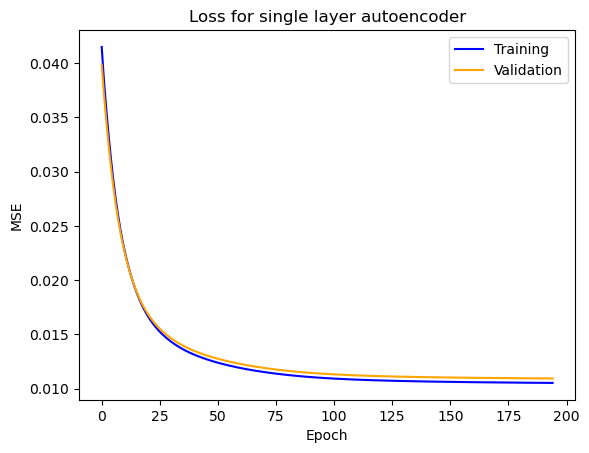

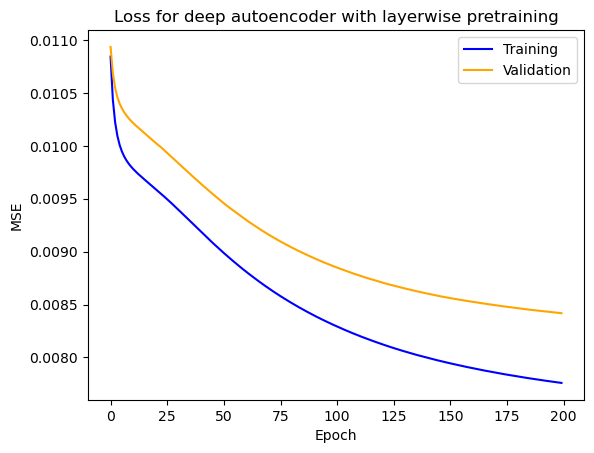

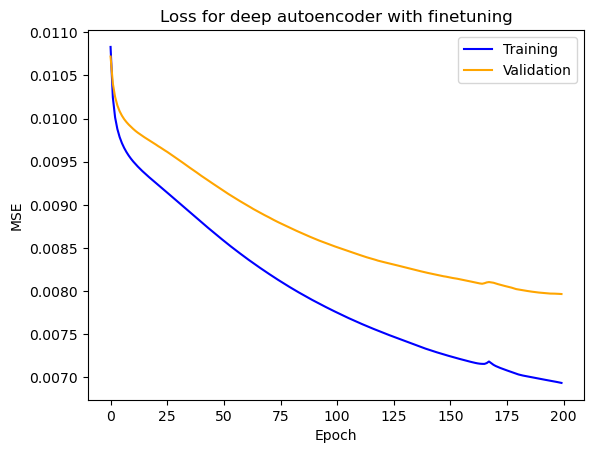

In [155]:
plot_loss(tr_loss_list_single[5:], val_loss_list_single[5:],
          "Loss for single layer autoencoder")
plot_loss(tr_loss_list_deep, val_loss_list_deep,
          "Loss for deep autoencoder with layerwise pretraining")
plot_loss(tr_loss_list_ft, val_loss_list_ft,
          "Loss for deep autoencoder with finetuning")

MSE values on the validation set for the three models. It is interesting to note how the loss for the deep autoencoder without finetuning is barely smaller than the single layer one. On the other hand, by finetuning the net much better results are obtained.

In [183]:
model.eval()
deep_model.eval()
deep_model_ft.eval()
print("Loss on validation set:")
with torch.no_grad():
  predictions = model(val_data_noisy)
  loss = criterion(predictions, val_target).data
  print(f"\tSingle layer autoencoder loss: {loss:.4f}")

  deep_predictions = deep_model(val_data_noisy)
  loss = criterion(deep_predictions, val_target).data
  print(f"\tDeep autoencoder with layerwise pretraining Loss: {loss:.4f}")
  
  deep_ft_predictions = deep_model_ft(val_data_noisy)
  loss = criterion(deep_ft_predictions, val_target).data
  print(f"\tDeep autoencoder with finetuning Loss: {loss:.4f}")

Loss on validation set:
	Single layer autoencoder loss: 0.0109
	Deep autoencoder with layerwise pretraining Loss: 0.0084
	Deep autoencoder with finetuning Loss: 0.0080


MSE values on the test set for the three models.

In [157]:
model.eval()
deep_model.eval()
deep_model_ft.eval()
print("Loss on test set:")
with torch.no_grad():
  test_predictions = model(ts_data_noisy)
  loss = criterion(test_predictions, ts_target).data
  print(f"\tSingle layer autoencoder loss: {loss:.4f}")

  test_deep_predictions = deep_model(ts_data_noisy)
  loss = criterion(test_deep_predictions, ts_target).data
  print(f"\tDeep autoencoder with layerwise pretraining Loss: {loss:.4f}")
  
  test_deep_ft_predictions = deep_model_ft(ts_data_noisy)
  loss = criterion(test_deep_ft_predictions, ts_target).data
  print(f"\tDeep autoencoder with finetuning Loss: {loss:.4f}")

Loss on test set:
	Single layer autoencoder loss: 0.0105
	Deep autoencoder with layerwise pretraining Loss: 0.0081
	Deep autoencoder with finetuning Loss: 0.0077


## Experiments

### Model testing

Comparisons between the original image, the noisy version, and the images reconstructed by the three models. One example for each digit is shown here.<br>
Overall it is possible to see that the single layer and deep autoencoders return similar images, generally managing to denoise the original image quite well. Some imperfections are still present though, like slightly changing the shape of the digit or having some white blur on the background. With finetuning these imperfections are reduced, and the digits appear sharper, more akin to the original non noisy versions.<br>
An interesting observation can be made by looking at some of the digits, but is most noticeable on the zero. In the original image there is an extra separate line from the main one composing the digit. All three models though try to erase it in their reconstructions, leaving only a slight blur. This makes sense as these quirks in handwriting may very well be interpreted as noise by the autoencoder, which reconstructs images the way it expects them to look.

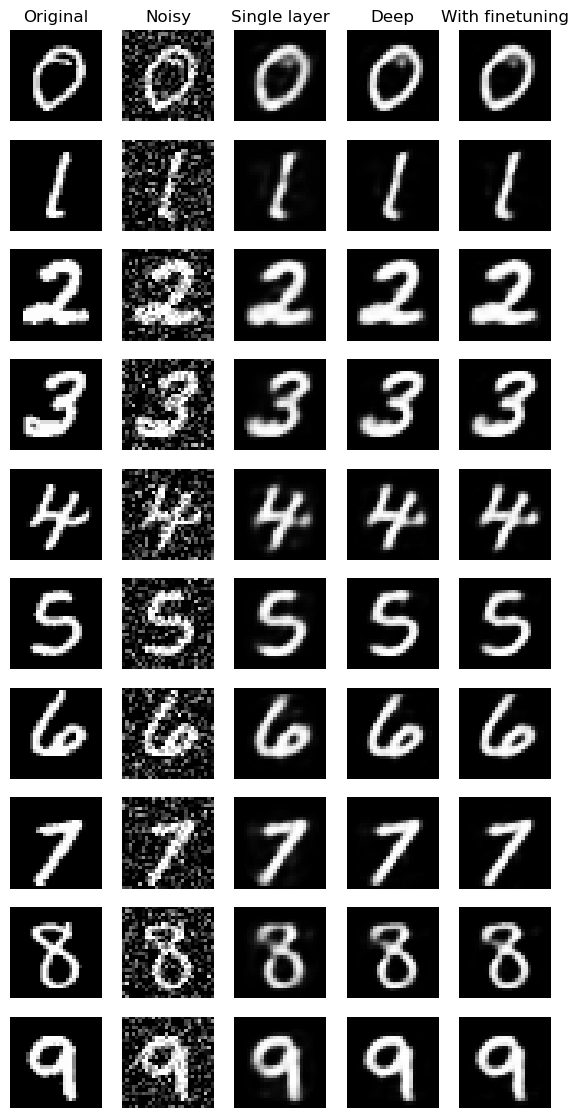

In [184]:
data_list = [val_data, val_data_noisy.cpu(), predictions.cpu(), 
             deep_predictions.cpu(), deep_ft_predictions.cpu()]
label_list = ["Original", "Noisy", "Single layer", "Deep",
              "With finetuning"]

indices = [2, 4, 27, 5, 13, 14, 9, 0, 16, 6]
plot_comparison(data_list, label_list, indices, figsize=(7, 14))

Something that might be interesting to check is how the three autoencoders behave when the input image has varying amounts of noise. Here different scales of noise are tested.<br>
It is easy to see that the single layer autoencoder actually has trouble reconstructing an image without noise, and only really works properly at the same level of noise used in training. The deep autoencoder without finetuning manages to get better results in this case, but still has trouble as soon as the amount of noise is increased. Finally, the version with finetuning actually manages to get decent results even while increasing noise further than what was used while training the model. Of course increasing noise even more basically destroys the image, so it is unsurprising that the model stops working properly, as it is basically being fed a random input. Sometimes it might be able to get a decent output but it is not consistent.

Loss on validation data with added noise at scale 0:
	Single layer autoencoder loss: 0.0341
	Deep autoencoder with layerwise pretraining Loss: 0.0135
	Deep autoencoder with finetuning Loss: 0.0062


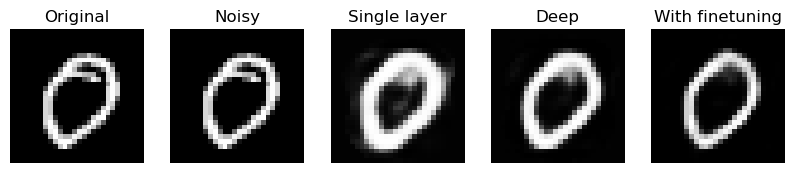

--------------------------------------------------
Loss on validation data with added noise at scale 0.3:
	Single layer autoencoder loss: 0.0109
	Deep autoencoder with layerwise pretraining Loss: 0.0084
	Deep autoencoder with finetuning Loss: 0.0080


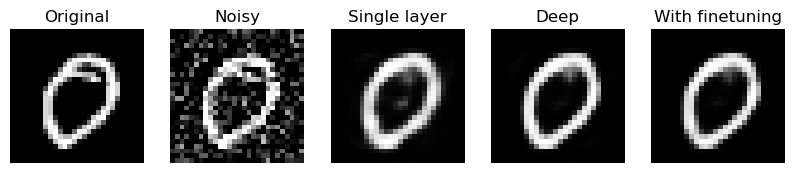

--------------------------------------------------
Loss on validation data with added noise at scale 0.5:
	Single layer autoencoder loss: 0.0311
	Deep autoencoder with layerwise pretraining Loss: 0.0233
	Deep autoencoder with finetuning Loss: 0.0159


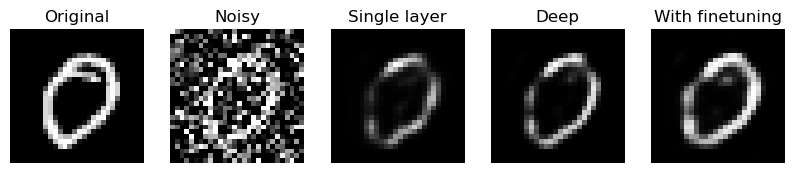

--------------------------------------------------
Loss on validation data with added noise at scale 0.7:
	Single layer autoencoder loss: 0.0622
	Deep autoencoder with layerwise pretraining Loss: 0.0482
	Deep autoencoder with finetuning Loss: 0.0280


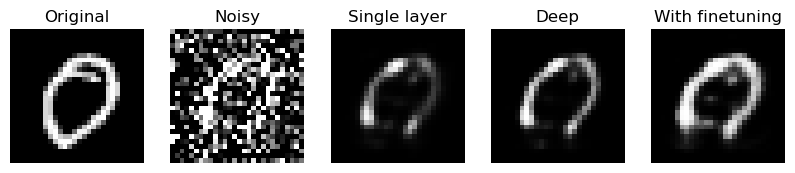

--------------------------------------------------


In [159]:
model.eval()
deep_model.eval()
deep_model_ft.eval()
scales = [0, 0.3, 0.5, 0.7]
index = 2

for scale in scales:
  val_data_noisy_tmp = (val_data + scale * 
                        torch.randn(val_data.shape)).to(device)
  val_data_noisy_tmp = torch.clip(val_data_noisy_tmp, 0, 1)
  print(f"Loss on validation data with added noise at scale {scale}:")
  with torch.no_grad():
    predictions = model(val_data_noisy_tmp)
    loss = criterion(predictions, val_target).data
    print(f"\tSingle layer autoencoder loss: {loss:.4f}")

    deep_predictions = deep_model(val_data_noisy_tmp)
    loss = criterion(deep_predictions, val_target).data
    print(f"\tDeep autoencoder with layerwise pretraining Loss: {loss:.4f}")
    
    deep_ft_predictions = deep_model_ft(val_data_noisy_tmp)
    loss = criterion(deep_ft_predictions, val_target).data
    print(f"\tDeep autoencoder with finetuning Loss: {loss:.4f}")

  data_list = [val_data, val_data_noisy_tmp.cpu(), predictions.cpu(), 
              deep_predictions.cpu(), deep_ft_predictions.cpu()]
  label_list = ["Original", "Noisy", "Single layer", "Deep",
                "With finetuning"]
  plot_comparison(data_list, label_list, index, figsize=(10, 3))
  print("-"*50)

### Latent space interpolation experiments
The experiments in this section will be done only using the deep autoencoder with finetuning, as it gives the encoding of highest quality among the ones obtained, as one would expect.<br>
The first thing to do is obtain the encoding of the data.

In [160]:
import ipywidgets as widgets
from ipywidgets import interact

In [161]:
deep_model_ft.eval()
with torch.no_grad():
    encoded_val = deep_model_ft.encode(val_data_noisy)

In [162]:
def interpolate(data1, data2, alpha: 0.5):
    if alpha < 0 or alpha > 1:
        raise ValueError("Parameter a must be in range [0, 1]")
    with torch.no_grad():
        interpolation = (alpha * data1 + (1 - alpha) * data2)
    return interpolation

In [163]:
def plot_interpolation(model, index1=0, index2=1, alpha=0.5):
    with torch.no_grad():
        interpolation = interpolate(encoded_val[index1], encoded_val[index2], alpha)
        interpolation = torch.reshape(interpolation, (1, 50))
        decoded_val = model.decode(interpolation).cpu()
        decoded_val = torch.reshape(decoded_val, (28, 28))
    plt.figure(figsize=(3,3))
    plt.imshow(decoded_val, cmap="gray")
    plt.axis("off")
    plt.show()

In [185]:
index1 = 0
index2 = 1
interact(plot_interpolation, model=widgets.fixed(deep_model_ft), index1=widgets.fixed(index1), index2=widgets.fixed(index2), alpha=(0, 1, 0.05));

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes…

In [190]:
index1 = 1
index2 = 4
interact(plot_interpolation, model=widgets.fixed(deep_model_ft), index1=widgets.fixed(index1), index2=widgets.fixed(index2), alpha=(0, 1, 0.05));

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes…

In [166]:
index1 = 14
index2 = 5
interact(plot_interpolation, model=widgets.fixed(deep_model_ft), index1=widgets.fixed(index1), index2=widgets.fixed(index2), alpha=(0, 1, 0.05));

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes…

In [187]:
index1 = 13
index2 = 6
interact(plot_interpolation, model=widgets.fixed(deep_model_ft), index1=widgets.fixed(index1), index2=widgets.fixed(index2), alpha=(0, 1, 0.05));

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes…

# Final Remarks

TODO final remarks

# Extras

In [168]:
def plot_average_digits(model, data, labels):
  fig, axes = plt.subplots(1, 10, figsize=(15, 3))
  for i in range(10):
    ax = axes[i]

    filtered_data = data[torch.where(labels == i)]
    avg_data = torch.mean(filtered_data, 0)
    
    with torch.no_grad():
      avg_data = torch.reshape(avg_data, (1, 50))
      decoded_data = model.decode(avg_data)

    ax.imshow(decoded_data[0].cpu(), cmap="gray")
    ax.axis("off")

  plt.show()

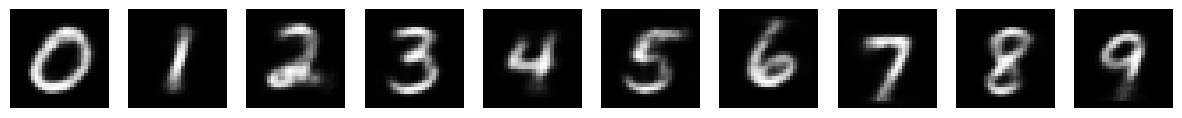

In [169]:
plot_average_digits(deep_model_ft, encoded_val, val_labels)

In [170]:
def plot_noisy_average_digits(model, data, labels, scale=0.1):
  
  fig, axes = plt.subplots(1, 10, figsize=(15, 3))
  for i in range(10):
    ax = axes[i]

    filtered_data = data[torch.where(labels == i)]
    avg_data = torch.mean(filtered_data, 0).to(device)
    avg_data += scale * torch.randn(avg_data.shape).to(device)
    with torch.no_grad():
      avg_data = torch.reshape(avg_data, (1, 50))
      decoded_data = model.decode(avg_data)

    ax.imshow(decoded_data[0].cpu(), cmap="gray")
    ax.axis("off")

  plt.show()

In [171]:
interact(plot_noisy_average_digits, model=widgets.fixed(deep_model_ft), data=widgets.fixed(encoded_val), labels=widgets.fixed(val_labels), scale=(0, 1, 0.1));

interactive(children=(FloatSlider(value=0.1, description='scale', max=1.0), Output()), _dom_classes=('widget-i…

In [172]:
import pandas
import plotly.express as px


In [173]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_val.cpu())
fig = px.scatter(tsne_results, x=0, y=1,
                 color=val_labels,
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()